<a href="https://colab.research.google.com/github/Naresh-812/Introduction_to_ML/blob/main/RNN_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/idea_stock.csv")

In [4]:
# Data Exploration and Cleaning
print(data.head(10))  # Display the first 10 rows


         Date  series   OPEN   HIGH   LOW   PREV. CLOSE   ltp   close   vwap   \
0  19-Jun-2025      EQ   6.72   6.72  6.29          6.56  6.32    6.33   6.45   
1  18-Jun-2025      EQ   6.60   6.70  6.52          6.60  6.56    6.56   6.60   
2  17-Jun-2025      EQ   6.67   6.74  6.58          6.69  6.61    6.60   6.64   
3  16-Jun-2025      EQ   6.67   6.77  6.47          6.67  6.66    6.69   6.62   
4  13-Jun-2025      EQ   6.68   6.73  6.60          6.78  6.71    6.67   6.67   
5  12-Jun-2025      EQ   7.01   7.01  6.75          6.94  6.77    6.78   6.84   
6  11-Jun-2025      EQ   6.96   7.17  6.90          6.97  6.93    6.94   7.03   
7  10-Jun-2025      EQ   7.05   7.07  6.94          7.05  6.96    6.97   6.99   
8  09-Jun-2025      EQ   6.92   7.14  6.91          6.92  7.07    7.05   7.04   
9  06-Jun-2025      EQ   6.82   6.95  6.78          6.82  6.94    6.92   6.88   

   52W H   52W L        VOLUME              VALUE  No of trades   
0   19.18    6.29  64,10,47,602  4,13,34,

In [5]:
# Number of days in the dataset
print(len(data))

250


In [6]:
data.info()
print("Missing values:\n", data.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           250 non-null    object 
 1   series         250 non-null    object 
 2   OPEN           250 non-null    float64
 3   HIGH           250 non-null    float64
 4   LOW            250 non-null    float64
 5   PREV. CLOSE    250 non-null    float64
 6   ltp            250 non-null    float64
 7   close          250 non-null    float64
 8   vwap           250 non-null    float64
 9   52W H          250 non-null    float64
 10  52W L          250 non-null    float64
 11  VOLUME         250 non-null    object 
 12  VALUE          250 non-null    object 
 13  No of trades   250 non-null    object 
dtypes: float64(9), object(5)
memory usage: 27.5+ KB
Missing values:
 Date             0
series           0
OPEN             0
HIGH             0
LOW              0
PREV. CLOSE      0
ltp    

In [7]:
data.isnull().sum() # no missing values :)
missing_data = data.isnull().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info

,Missing values,Percentage
Date,0,0.0
series,0,0.0
OPEN,0,0.0
HIGH,0,0.0
LOW,0,0.0
PREV. CLOSE,0,0.0
ltp,0,0.0
close,0,0.0
vwap,0,0.0
52W H,0,0.0


In [13]:
data.columns = data.columns.str.strip()


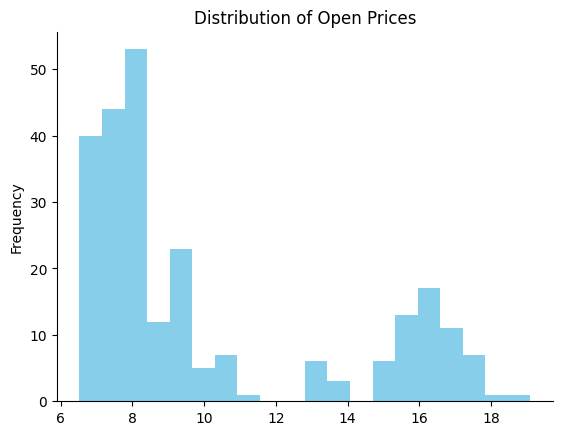

In [14]:
# Plot Open prices distribution
data['OPEN'].plot(kind='hist', bins=20, title='Distribution of Open Prices', color='skyblue')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [15]:
# Convert 'Date' column to datetime for proper manipulation
data['Date'] = pd.to_datetime(data['Date'])

In [16]:
print(data.head(10))

        Date series  OPEN  HIGH   LOW  PREV. CLOSE   ltp  close  vwap  52W H  \
0 2025-06-19     EQ  6.72  6.72  6.29         6.56  6.32   6.33  6.45  19.18   
1 2025-06-18     EQ  6.60  6.70  6.52         6.60  6.56   6.56  6.60  19.18   
2 2025-06-17     EQ  6.67  6.74  6.58         6.69  6.61   6.60  6.64  19.18   
3 2025-06-16     EQ  6.67  6.77  6.47         6.67  6.66   6.69  6.62  19.18   
4 2025-06-13     EQ  6.68  6.73  6.60         6.78  6.71   6.67  6.67  19.18   
5 2025-06-12     EQ  7.01  7.01  6.75         6.94  6.77   6.78  6.84  19.18   
6 2025-06-11     EQ  6.96  7.17  6.90         6.97  6.93   6.94  7.03  19.18   
7 2025-06-10     EQ  7.05  7.07  6.94         7.05  6.96   6.97  6.99  19.18   
8 2025-06-09     EQ  6.92  7.14  6.91         6.92  7.07   7.05  7.04  19.18   
9 2025-06-06     EQ  6.82  6.95  6.78         6.82  6.94   6.92  6.88  19.18   

   52W L        VOLUME              VALUE No of trades  
0   6.29  64,10,47,602  4,13,34,88,749.45     3,93,913  
1   6

In [18]:
# Extract 'Open' and 'Close' columns
open_prices = data['OPEN'].values
close_prices = data['close'].values

In [19]:
# Normalize the data (if required)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))
open_prices_scaled = scaler.fit_transform(open_prices.reshape(-1, 1))

In [20]:
# Define time_step (e.g., 50 days)
time_step = 50

# Create input features (X) and target (y)
X = []
y = []

for i in range(time_step, len(close_prices_scaled)):
    X.append(close_prices_scaled[i - time_step:i, 0])  # Use closing prices as input
    y.append(open_prices_scaled[i, 0])  # Use opening prices as target

X = np.array(X)
y = np.array(y)

# Reshape X to be compatible with RNN/LSTM input shape
X = X.reshape(X.shape[0], X.shape[1], 1)

In [21]:
# Reshape X to 2D: (1642, 50)
X_reshaped = X.reshape(X.shape[0], -1)  # Flatten the last two dimensions

# Convert to DataFrames
X_train_df = pd.DataFrame(X_reshaped)  # Each column represents a timestep
y_train_df = pd.DataFrame(y, columns=['Target'])  # Single column for target values

# Combine X_train and y_train into a single DataFrame
combined_df = pd.concat([X_train_df, y_train_df], axis=1)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('train_data.csv', index=False)

print("Data saved to train_data.csv")

Data saved to train_data.csv


In [22]:
# Define the model
regressor = Sequential()
regressor.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
regressor.add(SimpleRNN(units=50, return_sequences=True))
regressor.add(SimpleRNN(units=50, return_sequences=True))
regressor.add(SimpleRNN(units=50, return_sequences=False))
regressor.add(Dense(units=1))  # Output layer

# Compile the model
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = regressor.fit(X, y, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - loss: 0.3976 - val_loss: 0.0202
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0470 - val_loss: 0.1411
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0268 - val_loss: 0.0216
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0078 - val_loss: 0.0044
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0074 - val_loss: 0.0030
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0044 - val_loss: 0.0093
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0038 - val_l

In [23]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 50, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,405 (208.62 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,604 (139.08 KB)

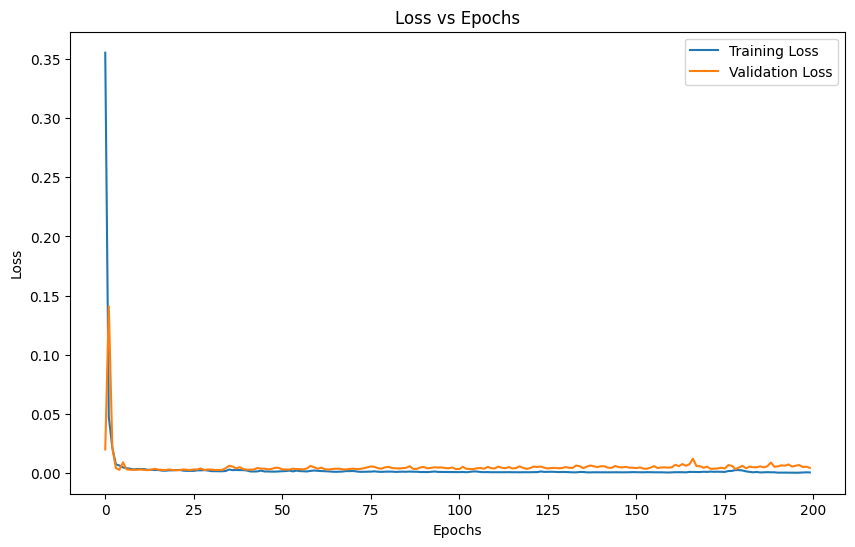

In [24]:
# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, 0.1)
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


In [25]:
# Lists to store actual and predicted opening prices
actual_open_prices = []
predicted_open_prices = []
days = []

# Loop through the dataset to generate predictions
for custom_day_index in range(time_step, len(close_prices_scaled)):
    # Get actual opening price
    actual_open_price = open_prices_scaled[custom_day_index, 0]

    # Prepare input for prediction
    X_input = close_prices_scaled[custom_day_index - time_step:custom_day_index]
    X_input = X_input.reshape(1, time_step, 1)  # Reshape for model input

    # Predict opening price
    predicted_open_price = regressor.predict(X_input, verbose=0)
    predicted_open_price = scaler.inverse_transform(predicted_open_price)  # Inverse transform to original scale

    # Append to lists
    actual_open_prices.append(scaler.inverse_transform([[actual_open_price]])[0, 0])
    predicted_open_prices.append(predicted_open_price[0, 0])
    days.append(custom_day_index + 1)

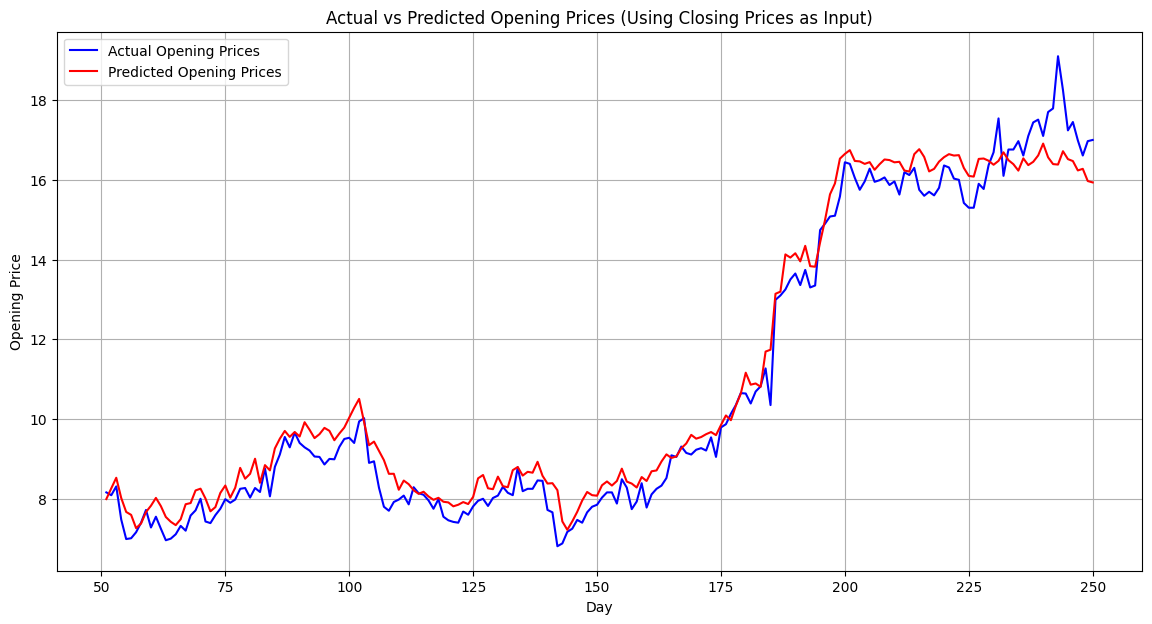

In [26]:
import matplotlib.pyplot as plt

# Plot actual vs predicted opening prices
plt.figure(figsize=(14, 7))
plt.plot(days, actual_open_prices, 'b-', label='Actual Opening Prices')
plt.plot(days, predicted_open_prices, 'r-', label='Predicted Opening Prices')
plt.title("Actual vs Predicted Opening Prices (Using Closing Prices as Input)")
plt.xlabel("Day")
plt.ylabel("Opening Price")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate error metrics
mae = mean_absolute_error(actual_open_prices, predicted_open_prices)
mse = mean_squared_error(actual_open_prices, predicted_open_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_open_prices, predicted_open_prices)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² (Coefficient of Determination): {r2:.4f}")

Mean Absolute Error (MAE): 0.4603
Mean Squared Error (MSE): 0.3283
Root Mean Squared Error (RMSE): 0.5730
R² (Coefficient of Determination): 0.9760


In [29]:
# Function to predict and print actual vs predicted value for a specific day
def predict_specific_day(specific_day_index, close_prices_scaled, open_prices_scaled, time_step, regressor, scaler):
    # Check if the specific day index is valid
    if specific_day_index < time_step or specific_day_index >= len(close_prices_scaled):
        print(f"Error: Invalid day index. Must be between {time_step} and {len(close_prices_scaled) - 1}.")
        return

    # Get actual opening price
    actual_open_price = open_prices_scaled[specific_day_index, 0]

    # Prepare input for prediction
    X_input = close_prices_scaled[specific_day_index - time_step:specific_day_index]
    X_input = X_input.reshape(1, time_step, 1)  # Reshape for model input

    # Predict opening price
    predicted_open_price = regressor.predict(X_input, verbose=0)
    predicted_open_price = scaler.inverse_transform(predicted_open_price)  # Inverse transform to original scale

    # Inverse transform the actual open price to original scale
    actual_open_price_original = scaler.inverse_transform([[actual_open_price]])[0, 0]

    # Print results
    print(f"Day {specific_day_index + 1}:")
    print(f"Actual Opening Price: {actual_open_price_original}")
    print(f"Predicted Opening Price: {predicted_open_price[0, 0]}")

# Example usage
specific_day_index = 93  # Replace with the day index you want to predict
specific_day_index -= 1
predict_specific_day(specific_day_index, close_prices_scaled, open_prices_scaled, time_step, regressor, scaler)

Day 93:
Actual Opening Price: 9.06
Predicted Opening Price: 9.521327018737793
